In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict

import matplotlib.animation as animation
from PIL import Image

In [9]:
is_hands_on = True

if is_hands_on:
    geom_df = pd.read_csv('Data/Output/Imaging_geometry_handsOn.csv')
    meas_df = pd.read_csv('Data/Output/Imaging_measurements_handsOn.csv')
else:
    geom_df = pd.read_csv('Data/Output/Imaging_geometry_handsOff.csv')
    meas_df = pd.read_csv('Data/Output/Imaging_measurements_handsOff.csv')


In [37]:
def interpret_X(val):
    if is_hands_on:
        diagnostic = 'C'
        val = int(val)
    else:   
        val = int(val)
        if val % 2 == 0:
            diagnostic = 'A'
        else:
            diagnostic = 'B'
        val = val//2
    return str(val) + diagnostic

def interpret_Xs(xs):
    joint = [interpret_X(x) for x in xs]
    orientations, diagnostics = np.array([[j[:-1], j[-1]] for j in joint]).T.tolist()
    return orientations, diagnostics

def split_by_name_geom(df):

    # Extract the 'X' value (second part of 'LOS_X_Y')
    if is_hands_on:
        df['X'] = df['LOS'].str.split('_').str[-1]  # Extract 'X'
    else:
        df['X'] = df['LOS'].str.split('_').str[1]  # Extract 'X'
    # Create separate DataFrames for each 'X'
    dfs = {interpret_X(x): sub_df.reset_index(drop=True) for x, sub_df in df.groupby('X')}
    
    return dfs

def split_by_name_meas(df):

    # Extract unique X values from column names

    grouped_columns = defaultdict(list)

    for col in df.columns:
        parts = col.split('_')  # Extract 'X' value from 'LOS_X_Y'
        if len(parts) > 2:  # Ensure it's in correct format
            if is_hands_on:
                x_value = parts[2]
            else:
                x_value = parts[1]  # Middle value is 'X'
            grouped_columns[x_value].append(col)

    # Create separate DataFrames for each 'X'
    dfs = {interpret_X(x): df[cols].reset_index(drop=True) for x, cols in grouped_columns.items()}

    return dfs

In [32]:

def tokamak_plasma_cross_section(R0=0.48, a=0.3, kappa=1.5, delta=0.3, num_points=200):
    """
    Generates a symmetric tokamak core plasma cross-section with elongation (κ) and triangularity (δ).

    Parameters:
        R0 (float): Major radius (center of the plasma).
        a (float): Minor radius (plasma width).
        kappa (float): Elongation factor (vertical stretching).
        delta (float): Triangularity factor (shaping).
        num_points (int): Number of points to generate for smoothness.

    Returns:
        x, y (numpy arrays): Coordinates of the tokamak plasma boundary.
    """
    theta = np.linspace(0, 2 * np.pi, num_points)

    # Parametric equations for the plasma boundary
    x = R0 + a * np.cos(theta) - delta * a * np.sin(theta) ** 2  # Add triangularity
    y = kappa * a * np.sin(theta)  # Apply elongation

    return x, y

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

class LOSPlotter:
    st_40_geometry = np.array(
        [[0.15, 0.95, 0.95, 0.15, 0.15], [0.7, 0.7, -0.7, -0.7, 0.7]]  # R  # z
    )
    is_single_color=False
    is_cbar=False
    diagnostic='A'
    colors = ['#16D5C2',  # Keppel
              '#16425B',  # Indigo
              '#EBF38B',  # Key Lime
              '#0000000',  # Black
              ]
    diagnostic_names = {
        'A': 'Bolometry',
        'B': 'Bremsstrahlung',
        'C': 'Bolometry',
    }   
    diagnostic_colors = {
        'A': '#16425B',  # Indigo
        'B': '#16D5C2',  # Keppel
        'C': '#16425B',  # Indigo
    }
    linestyles = {
        'A': '-',
        'B': '-',
        'C': '-',
    }
    linewidths = {
        'A': 2,
        'B': 2,
        'C': 2,
    }
    st_40_label = "ST40 Boundary"
    plasma_label = "Plasma Cross Section"
    is_hide_axis = False

    def __init__(self, measurement_df=None, geometry_df=None):
        self.split_geometry_df = split_by_name_geom(geometry_df)
        self.split_measurement_df = split_by_name_meas(measurement_df)
        print(self.split_geometry_df.keys())

        self.orientations = list(self.split_geometry_df.keys())  # Fix typo: use list()

        # Normalize color scale
        measurements = measurement_df.values.flatten()

        self.n_measurements = len(measurement_df.values)
        self.norm = plt.Normalize(measurements.min(), measurements.max())
        self.cmap = plt.cm.plasma

    def __call__(self, frame):
        """Update function for animation"""
        orientation = frame % len(self.orientations)
        self.plot_los(orientation=orientation, 
                      measurement=int(np.random.uniform(0, self.n_measurements, 1)),
                      diagnostic=self.diagnostic)

    def plot_los(self, orientation=0, measurement=100, diagnostic='A'):
        if hasattr(orientation, '__iter__'):
            orientations = orientation
        else:
            orientations = [orientation]
        if isinstance(diagnostic, (list, tuple)):
            diagnostics = diagnostic
        else:
            diagnostics = [diagnostic]
  
        if len(diagnostics) != len(orientations):
            if len(diagnostics) == 1:
                diagnostics = [diagnostics[0]] * len(orientations)
            elif len(orientations) == 1:
                orientations = [orientations[0]] * len(diagnostics)
            else:
                raise ValueError("Mismatched number of diagnostics and orientations")

        ax = self.ax
        """Plot function called inside animation"""
        ax.clear()
        
        is_orientation_unique = [sum([o==io for io in orientations]) == 1 for o in orientations]  
        sorted_indices = sorted(range(len(is_orientation_unique)), key=lambda i: is_orientation_unique[i])
        
        for i, (orientation, diagnostic, is_unique) in enumerate(zip(orientations, diagnostics, is_orientation_unique)):
            identifier = str(orientation) + diagnostic
            # Get data for current orientation
            orientation_df = self.split_geometry_df[identifier]
            measurement_df = self.split_measurement_df[identifier]
            selected_inds = np.arange(len(orientation_df))

            if not is_unique:
                if diagnostic == 'A':  
                    selected_inds = selected_inds[0::2]
                elif diagnostic == 'B':
                    selected_inds = selected_inds[1::2]
                    
            r_s = orientation_df['R start (m)']
            r_e = orientation_df['R end (m)']
            z_s = orientation_df['Z start']
            z_e = orientation_df['Z end']
            
            if self.is_cbar:
                colors = self.cmap(self.norm(measurement_df.values[measurement]))
            else:
                if self.is_single_color: 
                    colors = [self.diagnostic_colors[diagnostic]] * len(r_s)
                else:
                    colors = [self.colors[i % len(self.colors)]] * len(r_s)
                    
            linestyle = self.linestyles[diagnostic]
            linewidth = self.linewidths[diagnostic]
            # Plot the LOS lines
            for ind in selected_inds:
                ax.plot(
                    [r_s[ind], r_e[ind]],
                    [z_s[ind], z_e[ind]],
                    color=colors[ind],
                    lw=linewidth,
                    ls=linestyle,
                    label=self.diagnostic_names[diagnostic],
                    alpha=0.9
                )


        # Draw tokamak boundaries
        ax.plot(*self.st_40_geometry, "k-", lw=2, label=self.st_40_label)
        ax.plot(*tokamak_plasma_cross_section(), "k--", lw=1, label=self.plasma_label)
        ax.set_xlabel("Major Radius [m]")
        ax.set_ylabel("Height [m]")

        # Get unique legend entries
        # handles, labels = ax.get_legend_handles_labels()
        # unique = dict(zip(labels, handles))  # Removes duplicates

        # # Sort based on priority (items in priority_list come first)
        # priority_list = [self.st_40_label, self.plasma_label]
        # sorted_items = sorted(unique.items(), key=lambda x: priority_list.index(x[0]) if x[0] in priority_list else len(priority_list))
        # Get unique legend handles and labels
        priority_list = [self.st_40_label, self.plasma_label]
        handles, labels = ax.get_legend_handles_labels()
        unique = dict(zip(labels, handles))  # Ensure uniqueness

        # Sort based on priority (items in priority_list come first, rest go at the bottom sorted alphabetically)
        sorted_items = sorted(
            unique.items(),
            key=lambda x: (priority_list.index(x[0]) if x[0] in priority_list else len(priority_list) + ord(x[0][0]))  # Order unknown items alphabetically
        )

        # Extract sorted handles and labels
        sorted_handles, sorted_labels = zip(*sorted_items)
        # Apply sorted legend
        ax.legend(list(unique.values())[::-1],
                  list(unique.keys())[::-1],
                   ncol=1, loc="upper center", fontsize=8)

        # ax.legend(unique.values(), unique.keys(), ncol=1, loc="upper center", fontsize=8)
        # Set limits, labels, and aspect ratio
        # ax.set_xlim(0., 1)
        ax.set_ylim(-0.75, 1.)
        ax.set_aspect("equal")
        if self.is_hide_axis:
            ax.set_axis_off()  # Hides everything (spines, ticks, labels)

        
    def get_figure(self, is_cbar=False, dpi=300):
        self.is_cbar = is_cbar
        if is_cbar:
            # Create figure and axes once
            fig, axs = plt.subplots(1, 2, figsize=(6, 6), gridspec_kw={"width_ratios": [1, 0.05]}, dpi=dpi)
            ax, cbar_ax = axs  # Unpack subplots
            cbar = plt.colorbar(plt.cm.ScalarMappable(), cax=cbar_ax)  # Create persistent colorbar
            sm = plt.cm.ScalarMappable(cmap=self.cmap, norm=self.norm)
            plt.colorbar(sm, cax=cbar.ax, orientation="vertical")
            cbar.set_label("Sensor Measurement [Wm$^{-2}$]")
            fig.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1, wspace=0.01)

        else:
            fig, ax = plt.subplots(figsize=(3.8, 6), dpi=dpi)
            cbar = None
        
            fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.01)
        self.ax = ax
        return fig
        
    def static(self, orientation=0, measurement=100, is_cbar=False, name="indica_los", diagnostic='A', dpi=300, is_single_color=False):
        self.is_single_color = is_single_color
        fig = self.get_figure(is_cbar=is_cbar, dpi=dpi)
        self.plot_los(orientation=orientation, measurement=measurement, diagnostic=diagnostic)
        plt.savefig(f"Images/{name}.png", dpi=dpi)


    def animate(self, is_cbar=False, name="indica_los", fps=1, diagnostic='A', dpi=300, is_single_color=False):
        self.is_single_color = is_single_color
        self.diagnostic = diagnostic
        fig = self.get_figure(is_cbar=is_cbar, dpi=dpi)
        # Create animation
        anim = animation.FuncAnimation(fig, self, frames=6, repeat=True)

        # Save animation as GIF
        anim.save(f"Images/{name}.gif", writer="pillow", fps=fps)

        # Show animation
        plt.show()





In [71]:
# Initialize LOSPlotter
plotter = LOSPlotter(meas_df, geom_df)

dict_keys(['0C', '1C', '10C', '11C', '12C', '13C', '14C', '15C', '16C', '17C', '18C', '19C', '2C', '20C', '21C', '22C', '23C', '24C', '3C', '4C', '5C', '6C', '7C', '8C', '9C'])


['0', '12', '24'] ['C', 'C', 'C']


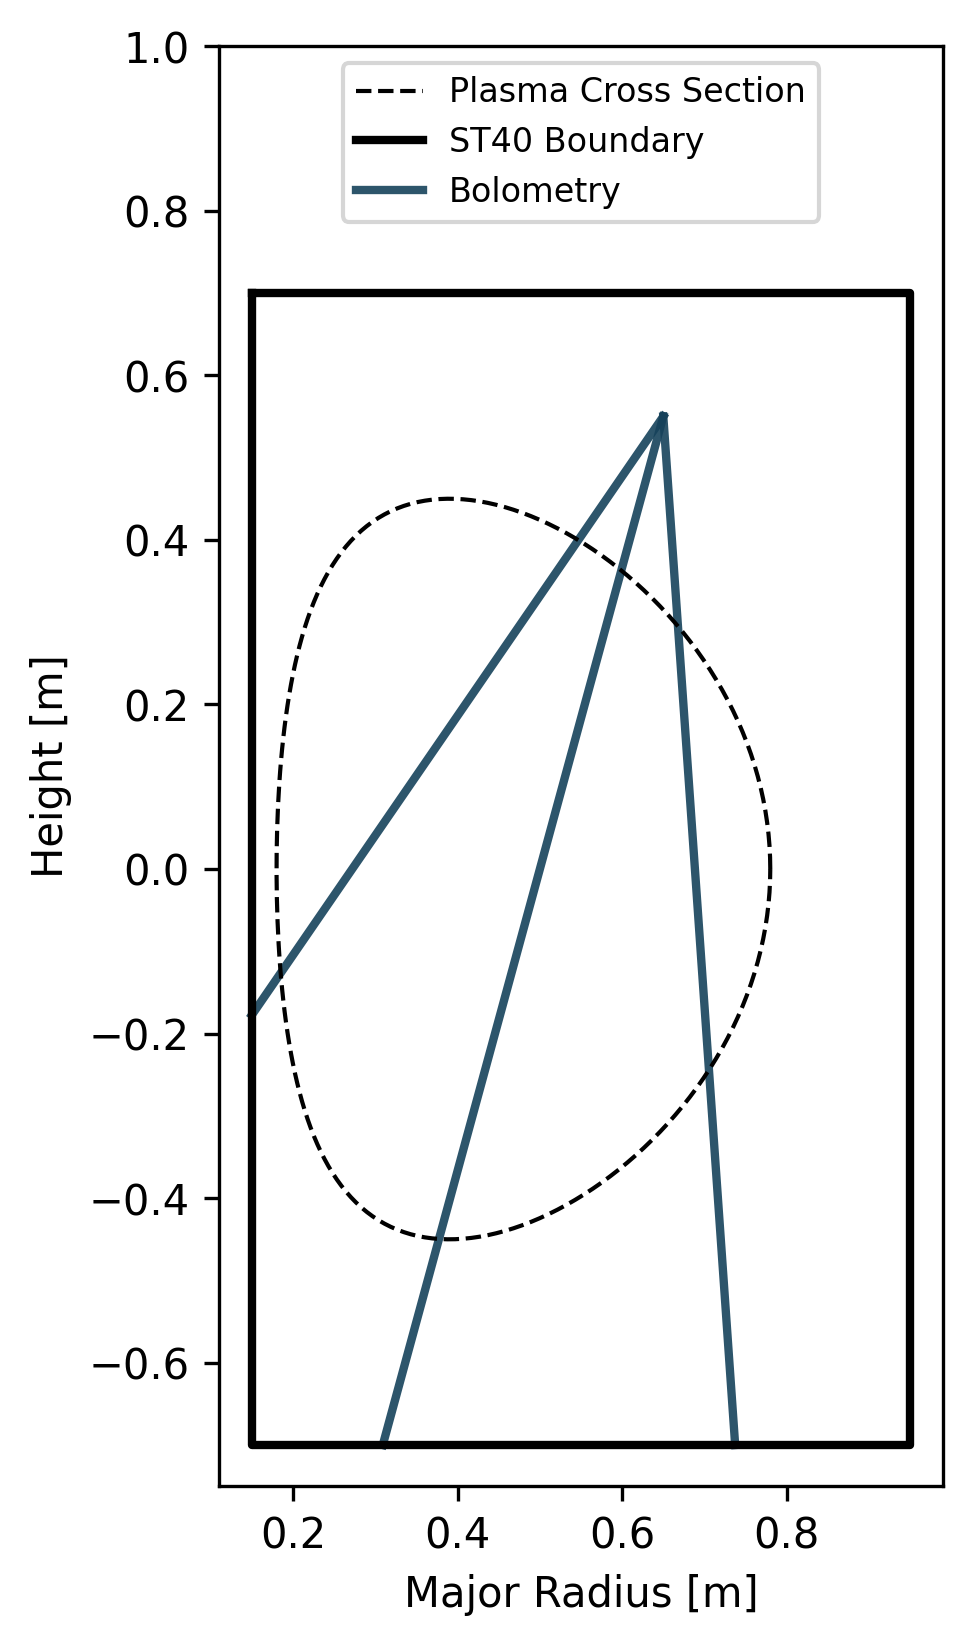

In [74]:
# BEST DESIGN (Complex)
xs = np.arange(25)
xs = [0, 12, 24]
# xs = [11, 12, 13]
orientation, diagnostic = interpret_Xs(xs)
print(orientation, diagnostic)
plotter.static(is_cbar=False, name=f"handson_los_{xs}", dpi=300,
                orientation=orientation, 
                diagnostic=diagnostic,
                is_single_color=True)

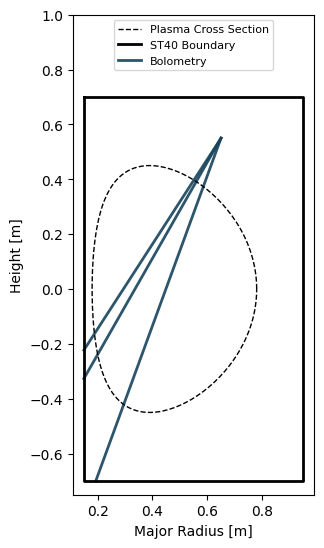

In [60]:
# WORST DESIGN
xs = [1, 3, 9]
orientation, diagnostic = interpret_Xs(xs)
plotter.static(is_cbar=False, name="indica_los_multi_diag_single_col", dpi=100,
                orientation=orientation, 
                diagnostic=diagnostic,
                is_single_color=True)

In [ ]:
# BEST DESIGN
xs = [1, 3, 9]
orientation, diagnostic = interpret_Xs(xs)
plotter.static(is_cbar=False, name="indica_los_multi_diag_single_col", dpi=100,
                orientation=orientation, 
                diagnostic=diagnostic,
                is_single_color=True)

In [ ]:
xs = np.arange(12)
orientation, diagnostic = interpret_Xs(xs)

plotter.animate(is_cbar=False,
                is_single_color=True,
                # orientation=orientation,
                diagnostic=diagnostic,
                 name="indica_los_single_colour")

In [ ]:
# BEST DESIGN (Complex)
xs = [3, 6, 9]
orientation, diagnostic = interpret_Xs(xs)
plotter.static(is_cbar=False, name=f"indica_los_{xs}", dpi=300,
                orientation=orientation, 
                diagnostic=diagnostic,
                is_single_color=True)

In [ ]:
plotter.static(is_cbar=True, name="indica_los_coloured", dpi=100)

In [ ]:
plotter.static(is_cbar=False, name="indica_los_multi", dpi=100, orientation=[0, 1, 2])

In [ ]:
plotter.static(is_cbar=False, name="indica_los_multi_single_col", dpi=100, orientation=[0, 1, 2], is_single_color=True)

In [ ]:
plotter.static(is_cbar=False, name="indica_los_multi_diag_single_col", dpi=100,
                orientation=[0, 1, 1], 
                diagnostic=['A', 'A', 'B'],
                is_single_color=True)

In [ ]:
plotter.animate(is_cbar=True, name="indica_los_coloured")

In [ ]:
plotter.animate(is_cbar=False, name="indica_los_single_colour")